In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from brax import envs
from brax.io import mjcf
import jax
import flax.linen as nn
import jax.numpy as jnp
from wrappers import AutoResetWrapper

from custom_types import RNGKey, EnvState, Params
from typing import Any, Tuple, List
# from algorithms import QuaraticPPO, PPO
# from mo_algorithms import MO_PPO
from algorithms import MOPPO, PPOConfigs
from res_ppo import ResPPO
from imitation_learning_emitter import ILConfigs, IL_emitter
from buffer import PPOTransition
from networks import GCMLP, GC_PPO_Policy, PPO_Policy, MLP
from functools import partial
from mo_utils import sample_task
# , mo_ppo_exploraive_rollout, calculate_td_lambda_returns, build_scoring_fn

/home/runjun/Documents/python_envs/jax/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
critic_hidden_layers: Tuple[int, ...] = (128, 128)
actor_hidden_layers: Tuple[int, ...] = (128, 128)
vec_env = 1024

ppo_config = PPOConfigs(
    policy_learnng_rate=5e-4,
    critic_learning_rate=5e-4,
    clip_ratio=0.2,
    entropy_gain=0.0,
    discount=0.99,
    td_lambda_discount=0.95,
    rollout_length=128,
    vec_env=vec_env,
    mini_batch_size=256,
    critic_epochs=4,
    policy_epochs=4,
    learnable_std=False,
    initial_std=0.1,
    std_decay_rate=0.0,
    min_std=0.1,
)


In [3]:
# set random seed
seed = 6666
loop_random_key = jax.random.PRNGKey(seed)
loop_random_key, subkey = jax.random.split(loop_random_key)
task_name = "ant"

# creat environment (Ant)
env = envs.create(env_name=task_name, episode_length=None, backend="positional", auto_reset=False)
env = AutoResetWrapper(env) # custom auto reset

In [ ]:
offspring_network = PPO_Policy(
    hidden_layer_sizes=actor_hidden_layers,
    action_dim=env.action_size,
    initial_std=0.1 * jnp.ones(env.action_size),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    kernel_init_final=jax.nn.initializers.orthogonal(0.01),
    # activation=nn.softplus,
    activation=nn.softplus,
    final_activation=jnp.tanh,
    fixed_std=True,
)

baseline_network = MLP(
    layer_sizes=critic_hidden_layers + (1,),
    kernel_init=jax.nn.initializers.orthogonal(jnp.sqrt(2)),
    # kernel_init_final=jax.nn.initializers.orthogonal(0.0),
    activation=nn.softplus,
    final_activation=None,
)


In [5]:
res_ppo = ResPPO(
    env,
    offspring_network,
    baseline_network,
    ppo_config,
    include_last_action_in_obs=True,
    )

subkey = jax.random.PRNGKey(42)
preference = sample_task(subkey)
loop_random_key, subkey = jax.random.split(loop_random_key)
fake_obs = jnp.zeros(shape=(env.observation_size + env.action_size,))


key1, key2 = jax.random.split(subkey)
policy = offspring_network.init(key1, fake_obs)
critic = baseline_network.init(key2, fake_obs)


ppo_training_state = partial(res_ppo.init, current_std=0.1)(
    policy,
    critic,
    preference,
    subkey,
    )

In [6]:
loop_random_key, subkey = jax.random.split(loop_random_key)
subkeys = jax.random.split(subkey, num=vec_env)
states = jax.vmap(env.reset)(subkeys)
last_actions = jnp.zeros((vec_env, env.action_size))

In [13]:
num_iterations = 500
iteration_mean_rewards = []
iteration_mean_returns = []


for i in range(num_iterations):
    
    (
        states, 
        last_actions, 
        ppo_training_state,
        loop_random_key,
    ), transitions = res_ppo.train(
        states,
        last_actions,
        ppo_training_state,
        loop_random_key,
    )

    iteration_mean_rewards.append(jnp.mean(transitions.rewards).item())
    iteration_mean_returns.append(jnp.mean(transitions.td_lambda_returns).item())

    if (i + 1) % max([(num_iterations // 10), 1]) == 0:
        print(int((i + 1) / num_iterations * 100), "% complete")

10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
100 % complete


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

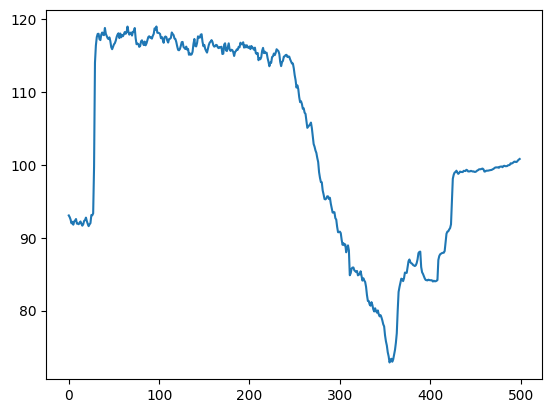

In [15]:
plt.plot(jnp.arange(num_iterations), iteration_mean_returns)
plt.show()

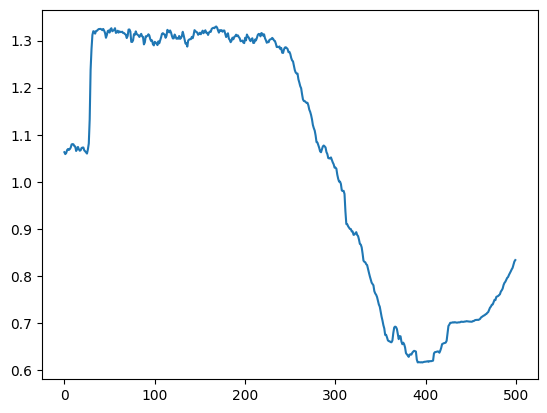

In [16]:
plt.plot(jnp.arange(num_iterations), iteration_mean_rewards)
# plt.plot(jnp.arange(num_iterations), iteration_mean_log_std)
plt.show()

In [17]:
print(preference)

[0.07658156 0.43643355 0.6388014  0.6289624 ]


In [18]:
jnp.mean(states.reward)

Array(1.5027571, dtype=float32)